In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import glob, os
import time

In [5]:
# LOAD AND SORT IMAGES FILENAMES INTO LISTS
image_dir = 'WashingtonOBRace'

img_filenames = glob.glob(os.path.join(image_dir, 'img_[0-9]*.png'))
img_filenames = sorted(img_filenames, key=lambda x:int(x[21:-4]))
print(f'Found {len(img_filenames)} image files in the directory "{image_dir}"')

mask_filenames = glob.glob(os.path.join(image_dir, 'mask_*.png'))
mask_filenames = sorted(mask_filenames, key=lambda x:int(x[22:-4]))
print(f'Found {len(mask_filenames)} mask files in the directory "{image_dir}"')

# READ AND STORE IMAGES AND MASKS INTO LISTS
imgs = [cv2.imread(filename, flags=cv2.IMREAD_COLOR) \
                                for filename in img_filenames]
imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in imgs]
print('loaded %d images' % len(imgs))

masks = [cv2.imread(filename, flags=cv2.IMREAD_GRAYSCALE) \
                                 for filename in mask_filenames]
print('loaded %d masks' % len(masks))

print(mask_filenames[:10])

Found 308 image files in the directory "WashingtonOBRace"
Found 308 mask files in the directory "WashingtonOBRace"
loaded 308 images
loaded 308 masks
['WashingtonOBRace/mask_6.png', 'WashingtonOBRace/mask_8.png', 'WashingtonOBRace/mask_9.png', 'WashingtonOBRace/mask_10.png', 'WashingtonOBRace/mask_11.png', 'WashingtonOBRace/mask_12.png', 'WashingtonOBRace/mask_13.png', 'WashingtonOBRace/mask_14.png', 'WashingtonOBRace/mask_18.png', 'WashingtonOBRace/mask_19.png']


In [14]:
queryImg = imgs[209] # queryImage
trainImg = imgs[210] # trainImage
queryMask = masks[209] # maskImage
trainMask = masks[210]
print(img_filenames[209])
print(img_filenames[210])
print(mask_filenames[209])
print(mask_filenames[210])

WashingtonOBRace/img_295.png
WashingtonOBRace/img_296.png
WashingtonOBRace/mask_295.png
WashingtonOBRace/mask_296.png


In [15]:
# SETUP
orb = cv2.ORB_create(nfeatures=300, WTA_K=2, scoreType=0)

queryKp = orb.detect(queryImg,None)
queryKps, queryDes = orb.compute(queryImg, queryKp)

index_params = dict(algorithm=6,
                    table_number=6,
                    key_size=12,
                    multi_probe_level=2)
search_params = {}
matcher = cv2.FlannBasedMatcher(index_params, search_params)

MIN_MATCH_COUNT = 10

In [16]:
# PROCESS INCOMING IMAGE FRAME
start_time = time.time()
trainKp = orb.detect(trainImg,None)
trainKps, trainDes = orb.compute(trainImg, trainKp)

# MATCH FEATURES
matches = matcher.knnMatch(queryDes, trainDes, k=8)

# FILTER GOOD MATCHES
good_matches = []

for candidates in matches:
    scores = np.zeros((len(candidates),))
    vert_popularity = np.zeros((len(candidates),))
    vert_similarity = np.zeros((len(candidates),))
    query_y = (queryKp[candidates[0].queryIdx].pt)[1] # NOTE: m.queryIdx == n.queryIdx
    
    for idx, candidate in enumerate(candidates):
        scores[idx] = candidate.distance
        train_cy = (trainKp[candidate.trainIdx].pt)[1]
        vert_popularity[idx] = train_cy
        vert_similarity[idx] = abs(query_y - train_cy)
    vert_popularity = abs(vert_popularity - np.median(vert_popularity))
    scores += 1 *vert_popularity + 0*vert_similarity
    
    scores = -scores
    scores -= np.min(scores)
    best_candidate = np.argmax(scores)
    best_score = scores[best_candidate]
    scores[best_candidate] = float('-inf')
    second_candidate = np.argmax(scores)
    if best_score > 1.25 * scores[second_candidate]:
        good_matches.append(candidates[best_candidate])
        
if len(good_matches) > MIN_MATCH_COUNT:
    src_pts = np.float32([queryKp[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    dst_pts = np.float32([trainKp[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    h,w = queryImg.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    
    PredMask = cv2.warpPerspective(queryMask, M, (trainImg.shape[1], trainImg.shape[0]))
    
else:
    print("Not enough matches are found - %d/%d" % (len(good_matches),MIN_MATCH_COUNT))
    matchesMask = None
    
end_time = time.time()
print("In {0} seconds.".format(end_time - start_time), end='\r')

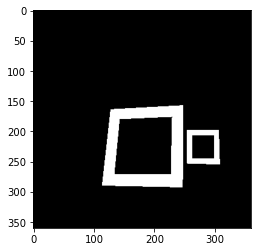

In [17]:
plt.imshow(queryMask, 'gray')
plt.show()

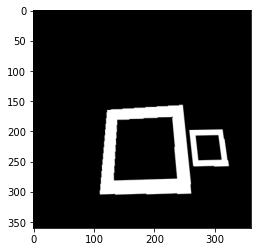

In [18]:
plt.imshow(PredMask, 'gray')
plt.show()

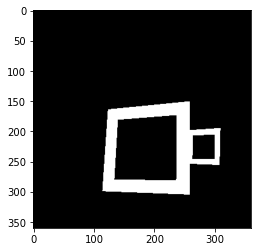

In [19]:
plt.imshow(trainMask, 'gray')
plt.show()

In [20]:
import ROC
import matplotlib.pyplot as plt

# Change ONLY the following line:
Values = PredMask

# make it a flat list of values, in the right order:
Values = Values.flatten();

classes = trainMask
classes[classes > 0] = 1
classes = classes.flatten()

# get the ROC curve:
TP, FP = ROC.get_ROC_curve(Values, classes)

Text(0.5, 0, 'FP')

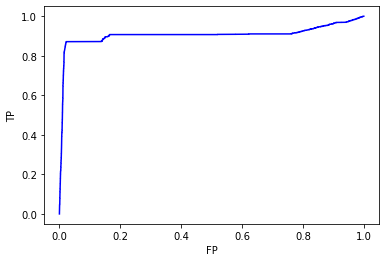

In [21]:
# plot the ROC curve:
plt.figure()
plt.plot(FP, TP, 'b')
plt.ylabel('TP')
plt.xlabel('FP')